In [127]:
from glob import glob
from itertools import cycle
import os
from typing import List, Union, Tuple

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Arrow, Rectangle, Polygon, Circle, PathPatch
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib.collections import PatchCollection, PolyCollection, LineCollection
import matplotlib.colors as mcolors
import numpy as np
import tensorflow as tf

from src.data_worker import YOLODataset, init_COCO
from src.utils import *
from src.disviz import setup_labels_plot

In [2]:
np.set_printoptions(suppress=True, precision=4)
%load_ext autoreload

In [21]:
%autoreload 2
%aimport src.utils
%aimport src.disviz
%aimport src.data_worker

In [8]:
color = cycle(["orange", "crimson", "tomato",
               "springgreen", "aquamarine", 
               "fuchsia", "deepskyblue", 
               "mediumorchid", "gold"])
images = sorted(glob("./data/images/train/*"))

In [9]:
data = init_COCO("./data/", ['train', 'val', 'test'])

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Found 269 train images
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Found 55 val images
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Found 60 test images


In [11]:
train_dataset = YOLODataset(data_name='train',
                            coco_obj=data,
                            image_path='./data/images/',
                            input_size=(1440, 1920),
                            target_size=(576, 768))

getting images for train set:
Found 269 files belonging to 1 classes.


In [168]:
val_dataset = YOLODataset(data_name='val',
                            coco_obj=data,
                            image_path='./data/images/',
                            input_size=(1440, 1920),
                            target_size=(576, 768))

getting images for val set:
Found 55 files belonging to 1 classes.


In [169]:
test_dataset = YOLODataset(data_name='test',
                            coco_obj=data,
                            image_path='./data/images/',
                            input_size=(1440, 1920),
                            target_size=(576, 768))

getting images for test set:
Found 60 files belonging to 1 classes.


In [131]:
os.path.abspath(train_dataset.x_path) + "/" + train_dataset.name + "/"

'/home/drew/code/school/phase5/ImageSegmentation/data/images/train/'

In [65]:
train_labels = train_dataset.annot_to_tensor()
# adj = tf.constant([[[768, 576, 768, 576]]], dtype=tf.float32)
# phi = (train_labels[..., -1:]  * 2 * np.pi) - np.pi
# train_labels_adj = train_labels[..., -5:-1] * adj
# train_labels = tf.concat([train_labels[..., :14], train_labels_adj, phi], axis=-1)
print(f"train_labels: {train_labels.shape}, {train_labels.dtype}")
# print(f"train_labels_adj: {train_labels_adj.shape}, {train_labels_adj.dtype}")
# print(f"phi: {phi.shape}")
print(f"train_labels[0]:\n{train_labels[0, 1]}")

train_labels: (269, 18, 19), float32
train_labels[0]:
[0.     0.     0.     0.     0.     0.     0.     1.     0.     0.
 0.     0.     0.     1.     0.5366 0.9156 0.0324 0.0434 0.5   ]


train_corners: (269, 18, 4, 2), <dtype: 'float32'>
train_corners:
[[424.528  539.9126]
 [424.528  514.8874]
 [399.648  514.8874]
 [399.648  539.9126]]


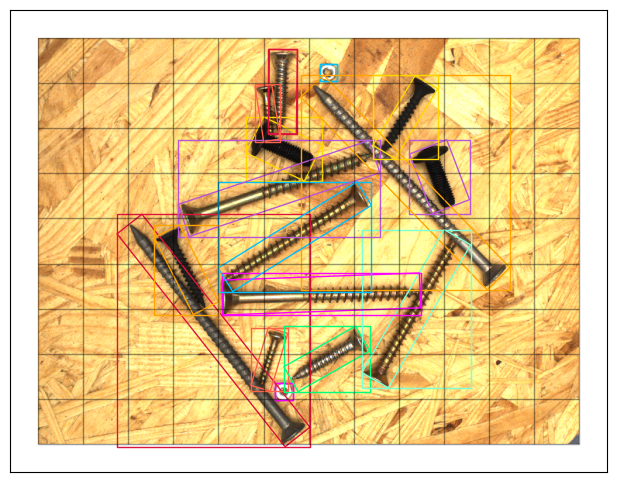

In [124]:
train_corners = get_corners(train_labels, img_width=768, img_height=576)
print(f"train_corners: {train_corners.shape}, {train_corners.dtype}")
print(f"train_corners:\n{train_corners[0, 1]}")

image = tf.keras.utils.load_img(images[0], target_size=(576, 768)) 
box = train_corners[0, 1]

dis_boxes = train_corners

img_sample = 0
box_collection = []
idx = 0
for i in dis_boxes[img_sample]:
    if tf.reduce_sum(i) == 0:
        continue
    n_color = next(color)
    xy, w, h = rect_vals[0, idx, 0:2], rect_vals[0, idx, 2], rect_vals[0, idx, 3]
    # box_collection.append(Circle(c, radius=5, color='springgreen'))
    box_collection.append(Rectangle(xy, w, h, color=n_color, fill=False))
    box_collection.append(Polygon(i, color=n_color, fill=False))
    idx += 1
box_collection = PatchCollection(box_collection, match_original=True)

fig, ax = setup_labels_plot()
ax[0].imshow(image)
ax[0].add_collection(box_collection)
plt.show()

In [123]:
def dis_std_annot(std_annot, image_size:List[int]=[768, 576]):
    cx, cy, w, h = std_annot[..., 1:2], std_annot[..., 2:3], std_annot[..., 3:4], std_annot[..., 4:]
    x = cx - w / 2 
    y = cy - h / 2
    min_xy = tf.concat([x, y], axis=-1) * tf.constant(image_size, shape=(1, 1, 2), dtype=tf.float32)
    print(min_xy.shape)
    width, height = w * image_size[0], h * image_size[1]

    return tf.concat([min_xy, width, height], axis=-1)
    
rect_vals = dis_std_annot(darknet_annot)
print(f"rect_vals: {rect_vals.shape}\n{rect_vals[0]}")

(269, 18, 2)
rect_vals: (269, 18, 4)
[[336.186   61.6474  25.6     25.0252]
 [399.648  514.8874  24.88    25.0252]
 [527.1908 326.5216  85.3064 105.1168]
 [294.9981 372.8928 107.9758  91.5745]
 [372.7953 218.6781 297.1372 304.9637]
 [112.0471  -4.1802 273.7978 330.2004]
 [302.1475  74.7153  52.1218  90.3294]
 [348.9547  74.1016 121.6507  92.9968]
 [459.4665  79.5291 154.571  224.7017]
 [261.1374 182.9748 281.8932  59.5703]
 [255.5225 216.2565 217.7086 155.727 ]
 [198.9722 294.3212 286.1757 136.3975]
 [475.4594 404.7592  91.8092 118.5616]
 [164.7998 183.5044  91.338  127.6311]
 [326.793  440.0239  41.3075 120.0322]
 [307.9866 429.0584  35.8259  81.4832]
 [  0.       0.       0.       0.    ]
 [  0.       0.       0.       0.    ]]


In [324]:
from glob import glob
import os
import shutil

class DarknetTools:
    def __init__(self, data:list, image_size:List[int], project_directory:str, make:bool=False):
        self.data = data
        self.image_size = image_size
        self.project_dir = self._check_path(project_directory)
        self.image_paths = self._image_paths()
        self.img_files = self._img_files()
        self.labels = self._annot_to_darknet()
        if make:
            self._create_project()

    def _image_paths(self):
        result = []
        for subset in self.data:
            result.append(os.path.abspath(subset.x_path) + "/" + subset.name)
        return result

    def _check_path(self, path):
        assert isinstance(path, str)

        if path.endswith('/'):
            path = path[:-1]
            return path
        else:
            return path

    def _create_project(self):
        if not os.path.exists(self.project_dir):
            os.mkdir(self.project_dir)
            os.mkdir(self.project_dir + "/obj")
            print(f"created project directory at:\n{self.project_dir}")

    def _img_files(self):
        results = [] 
        for idx, search_path in enumerate(self.image_paths):
            filenames = np.char.asarray(np.char.split(sorted(glob(search_path + "/*.png")), '/'), unicode=True)
            results.append(np.char.rstrip(filenames[..., -1], '.png'))

        return results

    def _annot_to_darknet(self, image_size:List[int]=[768, 576]):
        """
        Function that takes a YOLO_Dataset object and returns a tensor containing darknet formatted
        values.
        """
        # result = {}
        result = []
        for idx, div in enumerate(self.data):
            annot = div.annot_to_tensor()
            # Center Coordinate
            center = annot[..., 14:16]
            # Width and Height Values
            corners = tf.transpose(get_corners(annot, img_width=image_size[0], img_height=image_size[1]), perm=[0, 1, 3, 2])
            sorted_points = tf.sort(corners, direction='DESCENDING', axis=-1)
            max_xy, min_xy = tf.transpose(sorted_points[..., 0:1], perm=[0, 1, 3, 2]), tf.transpose(sorted_points[..., -1:], perm=[0, 1, 3, 2])
            wh = max_xy - min_xy
            width, height = wh[..., 0] / image_size[0], wh[..., 1] / image_size[1]
            # Class Label Values
            cls_label = tf.cast(tf.argsort(annot[..., :13], direction='DESCENDING', axis=-1)[..., 0:1], dtype=tf.float32)
            # result.update({f"{div.name}": tf.concat([cls_label, center, width, height], axis=-1).numpy()})
            result.append(tf.concat([cls_label, center, width, height], axis=-1).numpy())
     
        return result

    def save_annotations(self, path_to_project=None, backup_dir:str="/content/gdrive/MyDrive/colab_files/darknet_yolo/"):
        if not path_to_project:
            path_to_project = self.project_dir
        prefix = np.char.array(["data/obj/"], unicode=True)
        suffix = np.char.array([".png"], unicode=True)
        for idx, dataset in enumerate(self.data):
            assert(os.path.exists(f"{path_to_project}/obj"))
            txt = prefix + self.img_files[idx] + suffix
            np.savetxt(f"{path_to_project}/{dataset.name}.txt", txt, fmt='%-s')
            for itm, label in enumerate(self.labels[idx]):
                indices = np.where(np.sum(label, axis=-1) > 0)
                np.savetxt(f'{path_to_project}/obj/{self.img_files[idx][itm]}.txt',
                           label[indices],
                           fmt='%-u %.9f %.9f %.9f %.9f')

        class_num = int(np.max(self.labels[0][..., 0]) + 1)
        obj_data = [f"classes = {class_num}\n"]
        names = ["train", "valid", "test"]

        for name, dataset in zip(names, self.data):
            obj_data.append(f"{name} = data/{dataset.name}.txt\n")
        obj_data.extend(["names = data/obj.names\n", f"backup = {backup_dir}\n"])   

        with open(f"{path_to_project}/obj.data", 'w') as file:
            file.writelines(obj_data)

        with open(f"{path_to_project}/obj.names", 'w') as file2:
            class_names = [f"{x}\n" for x in range(class_num)]
            file2.writelines(class_names)
             



darknet = DarknetTools(data=[train_dataset, val_dataset, test_dataset], image_size=[768, 576], project_directory='./darknet_yolo', make=True)

In [325]:
darknet.save_annotations()

In [316]:
int(np.max(darknet.labels[0][..., 0]) + 1)

13

In [255]:
for idx, dataset in enumerate(darknet.data):
    print("-" * 40)
    print(f"{dataset.name}\n")
    print(f"img_names:      {darknet.img_files[idx].shape}")
    print(f"darknet_annots: {darknet.labels[idx].shape}")
    print(f"max value: {tf.reduce_max(darknet.labels[idx][..., 1:]).numpy()}")
    print(f"min value: {tf.reduce_min(darknet.labels[idx][..., 1:]).numpy()}")
    print("-" * 40)
    print(f"Sample Class Labels:")
    print(f"image: {darknet.img_files[idx][0]}")
    print(f"{darknet.labels[idx][0, :, 0]}")
# for idx, (name, annot) in enumerate(darknet_annots.items()):
#     print(name)
#     print(darknet.img_files[idx][0])
#     print(annot[0, 0])

----------------------------------------
train

img_names:      (269,)
darknet_annots: (269, 18, 5)
max value: 0.9590416550636292
min value: 0.0
----------------------------------------
Sample Class Labels:
image: screws_002
[7. 7. 8. 8. 2. 2. 4. 5. 3. 1. 3. 1. 6. 6. 5. 4. 0. 0.]
----------------------------------------
val

img_names:      (55,)
darknet_annots: (55, 18, 5)
max value: 0.9468749761581421
min value: 0.0
----------------------------------------
Sample Class Labels:
image: screws_001
[7. 3. 2. 2. 7. 8. 8. 6. 6. 5. 4. 5. 4. 1. 3. 1. 0. 0.]
----------------------------------------
test

img_names:      (60,)
darknet_annots: (60, 18, 5)
max value: 0.921875
min value: 0.0
----------------------------------------
Sample Class Labels:
image: screws_006
[7. 7. 2. 2. 1. 1. 3. 4. 4. 8. 8. 6. 6. 5. 5. 3. 0. 0.]
